In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import numpy as np
import os.path as osp

from geo_tool import Point_Cloud

from tf_lab.nips.helper import pclouds_centered_and_half_sphere, center_pclouds_in_unit_sphere
from tf_lab.iclr.helper import load_multiple_version_of_pcs
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.evaluate.generative_pc_nets import entropy_of_occupancy_grid, jensen_shannon_divergence, minimum_mathing_distance, coverage

In [3]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [35]:
# Parameters
class_name = 'chair'
n_pc_samples = 2048
do_mmd = True
do_jsd = False

# For JSD
cmp_in_sphere = True
voxel_resolution = 28
use_uniform_prior = False

# For MMD
reduce_gt = 1000
batch_size = 1000

def identity(x):
    return x

pc_normalizer = identity
pc_normalizer = center_pclouds_in_unit_sphere

In [13]:
# Load Wu Data, compute grid variable.
top_in_data = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/mit_wu_isosurface_extracted/'
wu_data = np.load(osp.join(top_in_data, class_name + '.npz'))
wu_data = pc_normalizer(wu_data[wu_data.keys()[0]])
assert(wu_data.shape[1] == n_pc_samples)

if do_jsd:
    _, wu_grid_var = entropy_of_occupancy_grid(wu_data, voxel_resolution, in_sphere=cmp_in_sphere)
    if use_uniform_prior:
        wu_grid_var += 1

In [14]:
# Load Ground-Truth Train Data (All data af the class.)
top_gt_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/gt_data/'

all_class_data = []
for split in ['train', 'test', 'val']:
    gt_file = osp.join(top_gt_dir, class_name + '_' + split + '.npz')
    gt_data = np.load(gt_file)
    gt_data = pc_normalizer(gt_data[gt_data.keys()[0]])
    all_class_data.append(gt_data)

all_class_data = np.vstack(all_class_data)

In [15]:
jsd_samples = []
n_samples = 5

if do_jsd:
    for _ in range(n_samples):
        n_wu = len(wu_data)
        gt_cmp_data = all_class_data[np.random.choice(np.arange(len(all_class_data)), n_wu)]
        _, gt_grid_var = entropy_of_occupancy_grid(gt_cmp_data, voxel_resolution, in_sphere=cmp_in_sphere)
        if use_uniform_prior:
            gt_grid_var += 1
        res = jensen_shannon_divergence(wu_grid_var, gt_grid_var)
        jsd_samples.append(res)
    print np.mean(jsd_samples)

In [36]:
from tf_lab.iclr.evaluator import Evaluator
evaluator = Evaluator(class_name, norm=pc_normalizer)
evaluator.load_gt_data()

In [41]:
wu_file = osp.join(top_in_data, class_name + '.npz')

In [42]:
boost_samples = 3
mmd_dist = 'chamfer'
skip = ['train', 'test' ]

evaluator.normalizer = center_pclouds_in_unit_sphere
evaluator.prepare_sample_data(rgan_file, boost_sample=boost_samples)

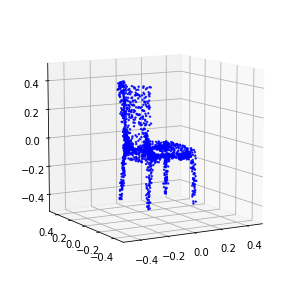

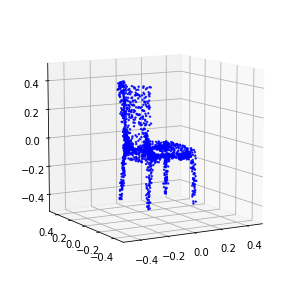

In [44]:
Point_Cloud(evaluator.sample_data['val'][0]).plot()

In [45]:
evaluator.compute_mmd(loss=mmd_dist, sample_estimator=False, skip=skip);
evaluator.compute_coverage(loss=mmd_dist, sample_estimator=False, skip=skip);

val 0.00214658 0.00130652
val 0.502958579882 0.0


In [11]:
# do_jsd = False
# do_mmd = True

# if do_jsd:
#     evaluator.prepare_gt_grid_variables()

# sample_files = [osp.join(syn_out_dir, 'samples.npz')]

# for sample_file in sample_files:
#     sample_name = osp.basename(sample_file)[:-len('.npz')]
#     print sample_name
#     if do_jsd:
#         evaluator.prepare_sample_data(sample_file, 1)
#         evaluator.compute_jsd(skip=skip)
#     else:
#         evaluator.prepare_sample_data(sample_file, boost_samples)
#         evaluator.compute_mmd(loss=mmd_dist, sample_estimator=False, skip=skip)

In [9]:
gt_cmp_data.shape

(1000, 2048, 3)

In [16]:
gt_cmp_data = all_class_data
if do_mmd:
    if reduce_gt is not None:
        rids = np.random.choice(np.arange(len(gt_cmp_data)), reduce_gt, replace=False)
        gt_cmp_data = gt_cmp_data[rids]            
        res = minimum_mathing_distance(wu_data, gt_cmp_data, batch_size=batch_size, normalize=True, use_EMD=False)[0]
        print res

0.00439837
